In [ ]:
#install.packages("MLmetrics")

In [49]:
library(tidyverse)
library(caret)
library(ranger)
library(vip)
#library(randomForest)
library(rfUtilities)
library(recipes)
library(pdp)

# Attrition

In [50]:
data("attrition", package = "modeldata")
# Job attrition data
attrition <- attrition %>% 
  mutate_if(is.ordered, .funs = factor, ordered = FALSE)

In [51]:
index_caret <- createDataPartition(attrition$Attrition, p = 0.8, list = FALSE)
attrition_train <- attrition[index_caret, ]
attrition_test  <- attrition[-index_caret, ]

In [52]:
model <- ranger(Attrition ~ .,
                data = attrition_train,
                importance = "impurity",
                classification = TRUE,
                probability = FALSE,
                num.trees = 50,
                min.node.size = 10,
               )

In [53]:
model

Ranger result

Call:
 ranger(Attrition ~ ., data = attrition_train, importance = "impurity",      classification = TRUE, probability = FALSE, num.trees = 50,      min.node.size = 10, ) 

Type:                             Classification 
Number of trees:                  50 
Sample size:                      1177 
Number of independent variables:  30 
Mtry:                             5 
Target node size:                 10 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error:             14.19 % 

In [54]:
data_to_eval = attrition_train
pred_train_class <- predict(model, data_to_eval)$predictions
confusionMatrix(
  data = relevel(pred_train_class, ref = "Yes"), 
  reference = relevel(data_to_eval$Attrition, ref = "Yes"),
  mode='prec_recall'
)

Confusion Matrix and Statistics

          Reference
Prediction Yes  No
       Yes 144   1
       No   46 986
                                          
               Accuracy : 0.9601          
                 95% CI : (0.9473, 0.9705)
    No Information Rate : 0.8386          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.8369          
                                          
 Mcnemar's Test P-Value : 1.38e-10        
                                          
              Precision : 0.9931          
                 Recall : 0.7579          
                     F1 : 0.8597          
             Prevalence : 0.1614          
         Detection Rate : 0.1223          
   Detection Prevalence : 0.1232          
      Balanced Accuracy : 0.8784          
                                          
       'Positive' Class : Yes             
                                          

In [55]:
data_to_eval = attrition_test
pred_train_class <- predict(model, data_to_eval)$predictions
confusionMatrix(
  data = relevel(pred_train_class, ref = "Yes"), 
  reference = relevel(data_to_eval$Attrition, ref = "Yes"),
  mode='prec_recall'
)

Confusion Matrix and Statistics

          Reference
Prediction Yes  No
       Yes   4   1
       No   43 245
                                          
               Accuracy : 0.8498          
                 95% CI : (0.8037, 0.8887)
    No Information Rate : 0.8396          
    P-Value [Acc > NIR] : 0.351           
                                          
                  Kappa : 0.1269          
                                          
 Mcnemar's Test P-Value : 6.37e-10        
                                          
              Precision : 0.80000         
                 Recall : 0.08511         
                     F1 : 0.15385         
             Prevalence : 0.16041         
         Detection Rate : 0.01365         
   Detection Prevalence : 0.01706         
      Balanced Accuracy : 0.54052         
                                          
       'Positive' Class : Yes             
                                          

# Online Intention

## Read data

- Administrative            
- Administrative_Duration   
- Informational             
- Informational_Duration    
- ProductRelated            
- ProductRelated_Duration   
- BounceRates               
- ExitRates                 
- PageValues                
- SpecialDay                
- Month                     
- OperatingSystems          
- Browser                   
- Region                    
- TrafficType               
- VisitorType               
- Weekend                   
- Revenue                   

In [56]:
path_data = '/home/creyesp/Projects/repos/r-course/data/online_shoppers_intention.csv'

column_parser <- cols(
    Administrative = col_character(),
    Administrative_Duration = col_double(),
    Informational = col_character(),
    Informational_Duration = col_double(),
    ProductRelated = col_character(),
    ProductRelated_Duration = col_double(),
    BounceRates = col_double(),
    ExitRates = col_double(),
    PageValues = col_double(),
    SpecialDay = col_double(),
    Month = col_character(),
    OperatingSystems = col_character(),
    Browser = col_character(),
    Region = col_character(),
    TrafficType = col_character(),
    VisitorType = col_character(),
    Weekend = col_character(),
    Revenue = col_character()
)

data = readr::read_delim(path_data, delim=',', col_types = column_parser)

In [57]:
dim(data)

[1] 12330    18

In [58]:
categorical = c(
    'Month',
    'VisitorType',
    'OperatingSystems',
    'Browser',
    'Region',
    'TrafficType',
    'Administrative',
    'Informational',
    'ProductRelated',
    'Weekend'
)
numerical = c(
    'Administrative_Duration',
    'Informational_Duration',
    'ProductRelated_Duration',
    'BounceRates',
    'ExitRates',
    'PageValues',
    'SpecialDay'
)
outcome = 'Revenue'

## Train/test split

In [59]:
index_train <- createDataPartition(data$Revenue, p = 0.8, list = FALSE)
retention_train <- data[index_train, ]
retention_test  <- data[-index_train, ]

## Overview
### General 

In [60]:
dim(retention_train)

[1] 9865   18

In [61]:
head(retention_train[categorical])

Month,VisitorType,OperatingSystems,Browser,Region,TrafficType,Administrative,Informational,ProductRelated,Weekend
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Feb,Returning_Visitor,1,1,1,1,0,0,1,FALSE
Feb,Returning_Visitor,2,2,1,2,0,0,2,FALSE
Feb,Returning_Visitor,3,3,1,4,0,0,10,TRUE
Feb,Returning_Visitor,2,2,1,3,0,0,19,FALSE
Feb,Returning_Visitor,2,4,3,3,0,0,1,FALSE
Feb,Returning_Visitor,1,2,1,5,1,0,1,TRUE


In [62]:
head(retention_train[numerical])

Administrative_Duration,Informational_Duration,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0.0000,0.20000000,0.2000000,0,0.0
0,0,64.0000,0.00000000,0.1000000,0,0.0
0,0,627.5000,0.02000000,0.0500000,0,0.0
0,0,154.2167,0.01578947,0.0245614,0,0.0
-1,-1,-1.0000,0.20000000,0.2000000,0,0.4
-1,-1,-1.0000,0.20000000,0.2000000,0,0.0


### Categorical 

In [63]:
lapply(retention_train[categorical], unique)

$Month
 [1] "Feb"  "Mar"  "May"  "Oct"  "June" "Jul"  "Aug"  "Nov"  "Sep"  "Dec" 

$VisitorType
[1] "Returning_Visitor" "New_Visitor"       "Other"            

$OperatingSystems
[1] "1" "2" "3" "4" "7" "6" "8" "5"

$Browser
 [1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "12" "13" "11"

$Region
[1] "1" "3" "2" "4" "9" "6" "7" "8" "5"

$TrafficType
 [1] "1"  "2"  "4"  "3"  "5"  "6"  "7"  "8"  "10" "11" "12" "9"  "13" "14" "15"
[16] "18" "19" "16" "17" "20"

$Administrative
 [1] "0"  "1"  "2"  "4"  "12" "3"  "10" "6"  "5"  "9"  "8"  "13" "11" "7"  "18"
[16] "14" "16" "17" "19" NA   "15" "24" "21" "20" "23" "27" "22" "26"

$Informational
 [1] "0"  "1"  "2"  "16" "5"  "3"  "4"  "14" "6"  "12" "7"  NA   "8"  "9"  "24"
[16] "10" "13"

$ProductRelated
  [1] "1"   "2"   "10"  "19"  "3"   "16"  "7"   "23"  "13"  "20"  "5"   "32" 
 [13] "4"   "45"  "8"   "14"  "52"  "9"   "46"  "15"  "22"  "11"  "12"  "36" 
 [25] "6"   "42"  "27"  "18"  "38"  "17"  "30"  "21"  "51"  "26"  "28"  "31" 
 [37] "24"  "96"  "49"  "68"  "98"  "67"  "55"  "50"  "37"  "29"  "71"  "87" 
 [49] "40"  "33"  "35"  "54"  "64"  "25"  "39"  "111" "81"  "61"  "44"  "149"
 [61] "41"  "0"   "47"  "79"  "66"  "43"  "258" "34"  "80"  "62"  "173" "48" 
 [73] "88"  "57"  "58"  "56"  "69"  "59"  "83"  "287" "63"  "78"  "137" "53" 
 [85] "113" "89"  "90"  "65"  NA    "104" "129" "77"  "82"  "74"  "76"  "72" 
 [97] "194" "140" "110" "60"  "132" "115" "73"  "93"  "75"  "160" "86"  "95" 
[109] "117" "124" "84"  "127" "125" "116" "105" "92"  "157" "154" "220" "131"
[121] "94"  "204" "142" "206" "102" "313" "145" "85"  "97"  "181" "126" "106"
[133] "112" "109" "101" "128" "108" "119" "70"  "122" "276" "114" "217" "187"
[145] "141" "133" "156" "136" "135" "91"  "99"  "362" "118" "175" "148" "440"
[157] "103" "178" "184" "705" "176" "146" "189" "120" "222" "121" "107" "130"
[169] "305" "199" "223" "179" "377" "310" "486" "230" "153" "139" "182" "221"
[181] "229" "216" "170" "202" "151" "274" "240" "162" "123" "227" "159" "168"
[193] "161" "429" "686" "167" "256" "255" "198" "358" "193" "155" "138" "237"
[205] "150" "271" "171" "414" "134" "172" "219" "262" "409" "243" "241" "143"
[217] "213" "391" "238" "152" "165" "293" "174" "584" "311" "340" "250" "164"
[229] "439" "200" "385" "292" "232" "251" "517" "100" "225" "169" "309" "235"
[241] "501" "224" "275" "318" "144" "397" "343" "245" "337" "351" "166" "349"
[253] "423" "280" "197" "359" "312" "147" "226" "324" "266" "260" "272" "534"
[265] "207" "326" "188" "190" "205" "186" "401" "177" "330" "286" "247" "357"
[277] "315" "231" "339" "283" "195" "248" "279" "281" "234" "261" "290" "336"
[289] "378" "183" "210" "192"

$Weekend
[1] "FALSE" "TRUE"

### Missing values

In [64]:
# Return the column names containing missing observations
list_na <- colnames(data)[ apply(retention_train, 2, anyNA) ]
list_na

[1] "Administrative"          "Administrative_Duration"
[3] "Informational"           "Informational_Duration" 
[5] "ProductRelated"          "ProductRelated_Duration"
[7] "BounceRates"             "ExitRates"

In [65]:
data.frame(missing = sapply(retention_train[numerical], function(x){sum(is.na(x))}))

,missing
,<int>
Administrative_Duration,12
Informational_Duration,12
ProductRelated_Duration,12
BounceRates,12
ExitRates,12
PageValues,0
SpecialDay,0


### Class balance

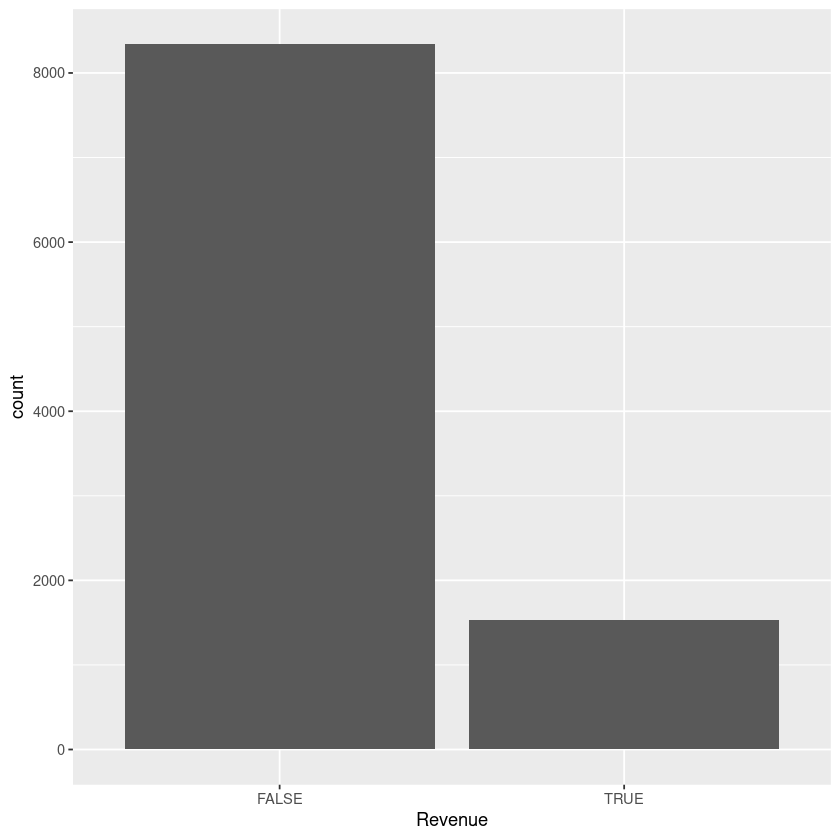

In [66]:
retention_train %>% 
    ggplot(aes(Revenue)) + 
        geom_bar()

## Feature engineering

Para mentener una consistencia en el trabajo de avaluacion de las metricas vamos a llevar siempre el target de los problemas de clasificación al tipo `factor` donde el primer nivel es el valor a predecir

In [67]:
all_of(numerical)

[1] "Administrative_Duration" "Informational_Duration" 
[3] "ProductRelated_Duration" "BounceRates"            
[5] "ExitRates"               "PageValues"             
[7] "SpecialDay"

In [68]:
retention_recipe <- recipe(Revenue ~ ., data = retention_train) %>%
    step_medianimpute(all_of(numerical)) %>% 
    step_string2factor(all_of(categorical)) %>% 
    step_knnimpute(all_of(categorical)) %>% 
    step_mutate(Revenue = factor(Revenue, labels=c("Yes", "No"), levels = c(TRUE, FALSE)))
    
prep_retention  <-  prep(retention_recipe)
retention_train_clean  <-  bake(prep_retention, retention_train)
retention_test_clean  <-  bake(prep_retention, retention_test)

In [69]:
data.frame(missing = sapply(retention_train_clean, function(x){sum(is.na(x))}))

,missing
,<int>
Administrative,0
Administrative_Duration,0
Informational,0
Informational_Duration,0
ProductRelated,0
ProductRelated_Duration,0
BounceRates,0
ExitRates,0
PageValues,0


In [70]:
head(retention_train_clean)

Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
0,0,0,0,1,0.0000,0.20000000,0.2000000,0,0.0,Feb,1,1,1,1,Returning_Visitor,FALSE,No
0,0,0,0,2,64.0000,0.00000000,0.1000000,0,0.0,Feb,2,2,1,2,Returning_Visitor,FALSE,No
0,0,0,0,10,627.5000,0.02000000,0.0500000,0,0.0,Feb,3,3,1,4,Returning_Visitor,TRUE,No
0,0,0,0,19,154.2167,0.01578947,0.0245614,0,0.0,Feb,2,2,1,3,Returning_Visitor,FALSE,No
0,-1,0,-1,1,-1.0000,0.20000000,0.2000000,0,0.4,Feb,2,4,3,3,Returning_Visitor,FALSE,No
1,-1,0,-1,1,-1.0000,0.20000000,0.2000000,0,0.0,Feb,1,2,1,5,Returning_Visitor,TRUE,No


In [71]:
retention_train_clean$Revenue

[1] No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No 
  [19] No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No 
  [37] No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No 
  [55] Yes No  No  No  No  No  No  No  No  Yes No  No  No  No  No  No  No  No 
  [73] No  No  No  No  No  No  No  No  No  No  No  No  Yes No  No  No  No  No 
  [91] No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No 
 [109] No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No 
 [127] No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No 
 [145] No  No  No  No  No  Yes No  No  No  No  No  No  Yes No  Yes Yes Yes No 
 [163] No  No  No  No  No  No  No  No  No  No  No  No  No  Yes No  No  No  No 
 [181] No  No  Yes No  No  No  No  No  No  No  No  No  No  No  No  No  No  No 
 [199] No  No  No  No  No  No  No  No  No  No  No  Yes No  No  No  No  No  No 
 [217] No  No  No  No  No  Yes No  No  No  No  No  No  No  No  Yes No  No  No 
 [235] No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No 
 [253] No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No 
 [271] No  No  No  No  No  No  No  Yes No  No  No  No  Yes No  No  No  No  No 
 [289] No  No  No  No  Yes No  No  No  No  No  No  No  No  No  No  No  Yes Yes
 [307] No  No  No  No  No  No  No  Yes No  No  No  No  No  No  No  Yes No  No 
 [325] No  No  No  Yes No  No  No  No  No  No  No  No  No  No  No  No  No  No 
 [343] No  No  No  No  No  No  No  No  No  No  No  No  Yes No  No  No  No  No 
 [361] No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No 
 [379] No  No  No  No  No  No  No  No  No  No  No  No  No  No  Yes No  No  No 
 [397] No  No  No  Yes No  No  No  No  No  No  No  No  No  No  No  No  No  No 
 [415] No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No 
 [433] No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No 
 [451] No  No  No  No  No  No  No  No  No  No  No  No  No  No  Yes No  No  No 
 [469] No  No  No  No  No  No  No  Yes No  No  No  Yes Yes No  Yes Yes No  No 
 [487] No  No  No  Yes No  No  No  No  No  No  No  Yes No  No  No  Yes No  No 
 [505] Yes No  No  No  No  No  Yes No  No  No  No  Yes No  No  No  No  No  No 
 [523] No  No  No  No  No  Yes No  No  No  No  No  No  No  No  No  No  No  No 
 [541] No  No  Yes No  No  No  No  No  No  No  No  No  No  No  Yes Yes No  Yes
 [559] No  No  No  Yes No  Yes No  No  No  No  No  No  No  No  No  No  No  Yes
 [577] No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No 
 [595] No  No  No  Yes Yes No  No  No  No  No  Yes No  Yes No  No  No  No  No 
 [613] No  No  No  No  Yes No  No  No  No  No  No  Yes No  No  No  No  No  No 
 [631] No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  Yes No  No 
 [649] No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  Yes
 [667] No  No  No  No  No  No  No  No  No  No  No  No  Yes No  No  No  No  Yes
 [685] No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  Yes No  No 
 [703] No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No 
 [721] No  Yes No  Yes No  No  No  No  No  No  No  No  No  No  No  No  No  No 
 [739] No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  Yes No 
 [757] No  No  No  No  No  No  No  No  Yes No  No  No  No  No  No  No  No  No 
 [775] No  No  No  No  No  No  No  No  No  No  No  No  No  Yes No  No  Yes No 
 [793] No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No 
 [811] No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No 
 [829] Yes No  No  Yes No  No  No  No  No  No  Yes No  Yes Yes No  No  No  No 
 [847] No  No  No  No  No  No  No  No  No  No  Yes Yes No  No  No  No  No  No 
 [865] No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No 
 [883] No  No  No  No  No  No  Yes No  No  No  No  No  No  No  No  No  No  No 
 [901] No  No  No  No  No  No  No  No  No  No  No  No

## Modeling

### Base Model

In [77]:
retention_model <- ranger(
    Revenue ~ .,
    data = retention_train_clean,
    importance = "impurity",
    classification = TRUE,
    probability = FALSE,
    #num.trees = 50,
    min.node.size = 3,
)

In [73]:
data_to_eval = retention_train_clean

pred_train_class <- predict(retention_model, data_to_eval)$predictions

confusionMatrix(
  data = (pred_train_class), 
  reference = data_to_eval$Revenue,
  mode='prec_recall'
)

Confusion Matrix and Statistics

          Reference
Prediction  Yes   No
       Yes 1516    0
       No    11 8338
                                         
               Accuracy : 0.9989         
                 95% CI : (0.998, 0.9994)
    No Information Rate : 0.8452         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.9957         
                                         
 Mcnemar's Test P-Value : 0.002569       
                                         
              Precision : 1.0000         
                 Recall : 0.9928         
                     F1 : 0.9964         
             Prevalence : 0.1548         
         Detection Rate : 0.1537         
   Detection Prevalence : 0.1537         
      Balanced Accuracy : 0.9964         
                                         
       'Positive' Class : Yes            
                                         

In [74]:
retention_model

Ranger result

Call:
 ranger(Revenue ~ ., data = retention_train_clean, importance = "impurity",      classification = TRUE, probability = FALSE, min.node.size = 3,      ) 

Type:                             Classification 
Number of trees:                  500 
Sample size:                      9865 
Number of independent variables:  17 
Mtry:                             4 
Target node size:                 3 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error:             9.68 % 

In [75]:
data_to_eval = retention_test_clean

pred_train_class <- predict(retention_model, data_to_eval)$predictions

cm <- confusionMatrix(
  data = pred_train_class, 
  reference = data_to_eval$Revenue,
  mode='prec_recall'
)
cm

Confusion Matrix and Statistics

          Reference
Prediction  Yes   No
       Yes  221   89
       No   160 1995
                                          
               Accuracy : 0.899           
                 95% CI : (0.8864, 0.9106)
    No Information Rate : 0.8454          
    P-Value [Acc > NIR] : 5.325e-15       
                                          
                  Kappa : 0.5816          
                                          
 Mcnemar's Test P-Value : 9.162e-06       
                                          
              Precision : 0.71290         
                 Recall : 0.58005         
                     F1 : 0.63965         
             Prevalence : 0.15456         
         Detection Rate : 0.08966         
   Detection Prevalence : 0.12576         
      Balanced Accuracy : 0.76867         
                                          
       'Positive' Class : Yes             
                                          

### VIP

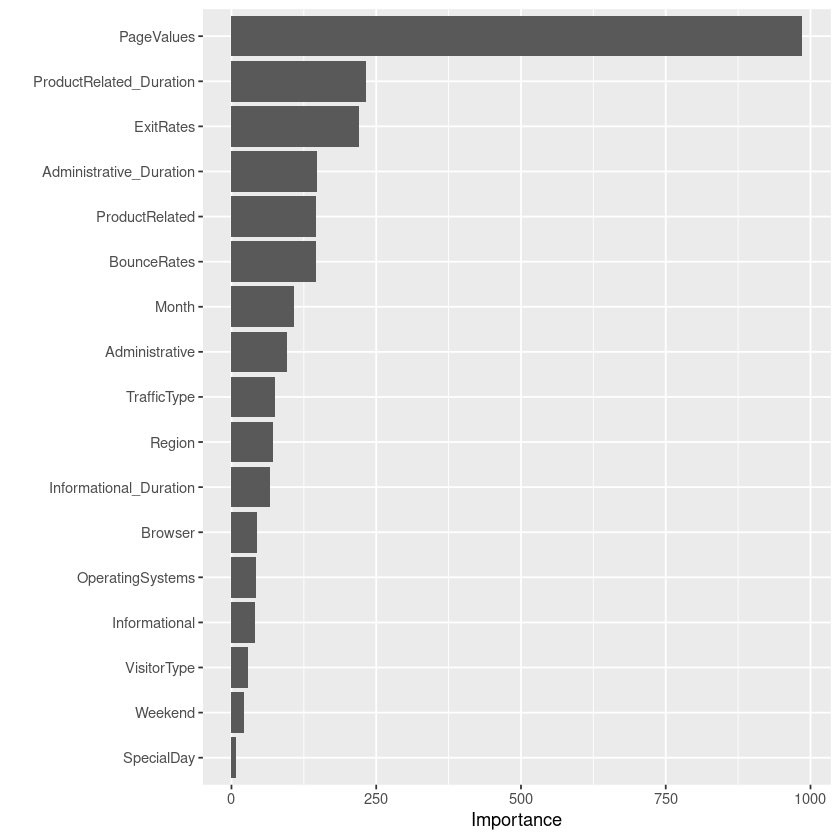

In [76]:
p1 <- vip::vip(retention_model, num_features = 25, )
p1

### Probability Calibration
        […] we desire that the estimated class probabilities are reflective of the true underlying probability of the sample. That is, the predicted class probability (or probability-like value) needs to be well-calibrated. To be well-calibrated, the probabilities must effectively reflect the true likelihood of the event of interest.

    — Page 249, Applied Predictive Modeling, 2013.
    

In [77]:
retention_model_prob <- ranger(
    Revenue ~ .,
    data = retention_train_clean,
    importance = "impurity",
    classification = TRUE,
    probability = TRUE,
    #num.trees = 50,
    min.node.size = 8,
)

In [86]:
predict(retention_model_prob, data_to_eval)$predictions

Yes,No
0.000000e+00,1.0000000
7.096774e-04,0.9992903
1.130000e-02,0.9887000
1.107143e-03,0.9988929
0.000000e+00,1.0000000
5.034524e-02,0.9496548
0.000000e+00,1.0000000
7.535714e-03,0.9924643
1.435714e-03,0.9985643
3.226190e-03,0.9967738


In [78]:
data_to_eval = retention_train_clean
pred_class <- factor(predict(retention_model_prob, data_to_eval)$predictions[, 1] > 0.5,
                           labels = c("Yes", "No"),
                           levels = c(TRUE, FALSE))
cm <- confusionMatrix(
  data = pred_class, 
  reference = data_to_eval$Revenue,
  mode='prec_recall'
)
cm

Confusion Matrix and Statistics

          Reference
Prediction  Yes   No
       Yes 1352    9
       No   175 8329
                                          
               Accuracy : 0.9813          
                 95% CI : (0.9785, 0.9839)
    No Information Rate : 0.8452          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9254          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
              Precision : 0.9934          
                 Recall : 0.8854          
                     F1 : 0.9363          
             Prevalence : 0.1548          
         Detection Rate : 0.1371          
   Detection Prevalence : 0.1380          
      Balanced Accuracy : 0.9422          
                                          
       'Positive' Class : Yes             
                                          

#### Calibration plot

In [79]:
data_to_eval = retention_train_clean

result_rF  <- data.frame(obs = data_to_eval$Revenue,
                         pred_prob = predict(retention_model_prob, data = data_to_eval)$predictions[, 1]
                        )
head(result_rF)

,obs,pred_prob
,<fct>,<dbl>
1,No,0.0000000000
2,No,0.0007096774
3,No,0.0113000000
4,No,0.0011071429
5,No,0.0000000000
6,No,0.0503452381


In [80]:
# Calibrating probabilities
cal_curve_ranger <- caret::calibration(x = as.factor(obs) ~ pred_prob, data = result_rF, class='Yes')
cal_curve_ranger$data

calibModelVar,bin,Percent,Lower,Upper,Count,midpoint
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
pred_prob,"[0,0.0909]",0.0000000,0.000000000,0.05281262,0,4.545455
pred_prob,"(0.0909,0.182]",0.0000000,0.000000000,0.53012866,0,13.636364
pred_prob,"(0.182,0.273]",0.2604167,0.006592962,1.44234119,1,22.727273
pred_prob,"(0.273,0.364]",4.5685279,2.110008229,8.49508156,9,31.818182
pred_prob,"(0.364,0.455]",56.6037736,48.523698525,64.43304161,90,40.909091
pred_prob,"(0.455,0.545]",89.5705521,83.827032104,93.80606422,146,50.000000
pred_prob,"(0.545,0.636]",97.9310345,94.072814052,99.57128024,142,59.090909
pred_prob,"(0.636,0.727]",99.5884774,97.728594952,99.98958169,242,68.181818
pred_prob,"(0.727,0.818]",100.0000000,98.817090923,100.00000000,310,77.272727


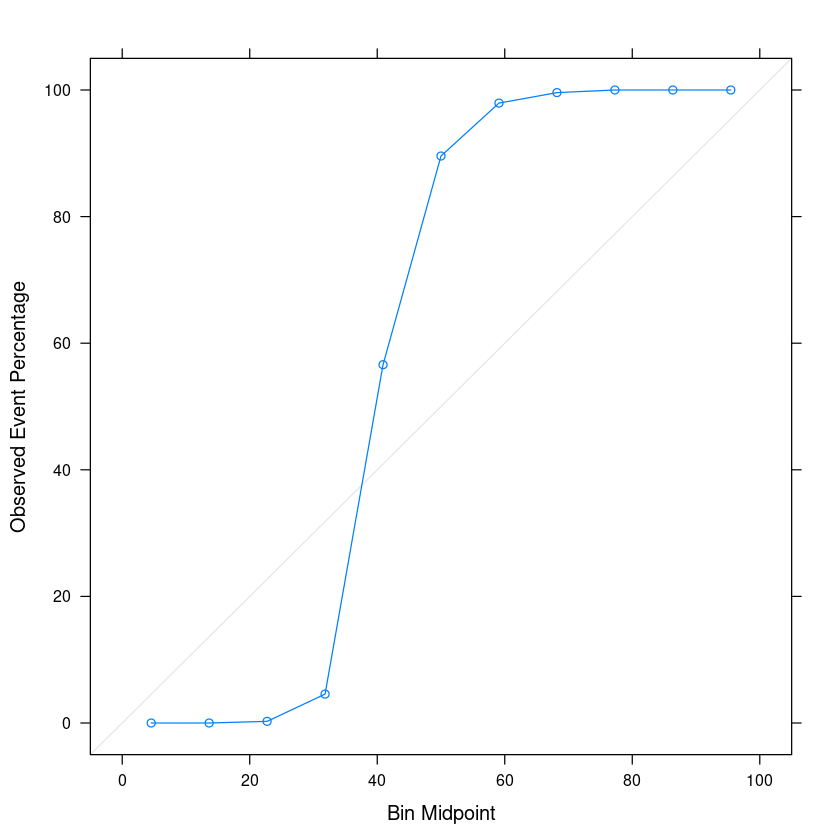

In [81]:
xyplot(cal_curve_ranger)

#### Calibrated prob

In [82]:
# Calibrate probabilities
result_rF$calibrated <- probability.calibration(y = as.numeric(factor(result_rF$obs, levels=c("No", "Yes")))-1,
                                                p = result_rF$pred_prob) 

In [83]:
head(result_rF)

,obs,pred_prob,calibrated
,<fct>,<dbl>,<dbl>
1,No,0.0000000000,0.000000e+00
2,No,0.0007096774,1.141419e-05
3,No,0.0113000000,1.817450e-04
4,No,0.0011071429,1.780688e-05
5,No,0.0000000000,0.000000e+00
6,No,0.0503452381,8.097343e-04


In [84]:
cal_curve_rF <- caret::calibration(
    x = as.factor(obs) ~ calibrated,
    data = result_rF,
    class='Yes',
    cuts=10
)
cal_curve_rF$data

calibModelVar,bin,Percent,Lower,Upper,Count,midpoint
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
calibrated,"[0,0.1]",0.09709916,0.04192955,0.1912339,8,5
calibrated,"(0.1,0.2]",10.52631579,1.30121644,33.1376664,2,15
calibrated,"(0.2,0.3]",23.33333333,9.93378650,42.2836523,7,25
calibrated,"(0.3,0.4]",100.00000000,2.50000000,100.0000000,1,35
calibrated,"(0.4,0.5]",33.33333333,0.84037587,90.5700676,1,45
calibrated,"(0.5,0.6]",61.90476190,45.63674955,76.4279453,26,55
calibrated,"(0.6,0.7]",65.85365854,54.55126788,75.9734515,54,65
calibrated,"(0.7,0.8]",84.61538462,69.47200756,94.1375737,33,75
calibrated,"(0.8,0.9]",91.08910891,83.75743910,95.8440530,92,85


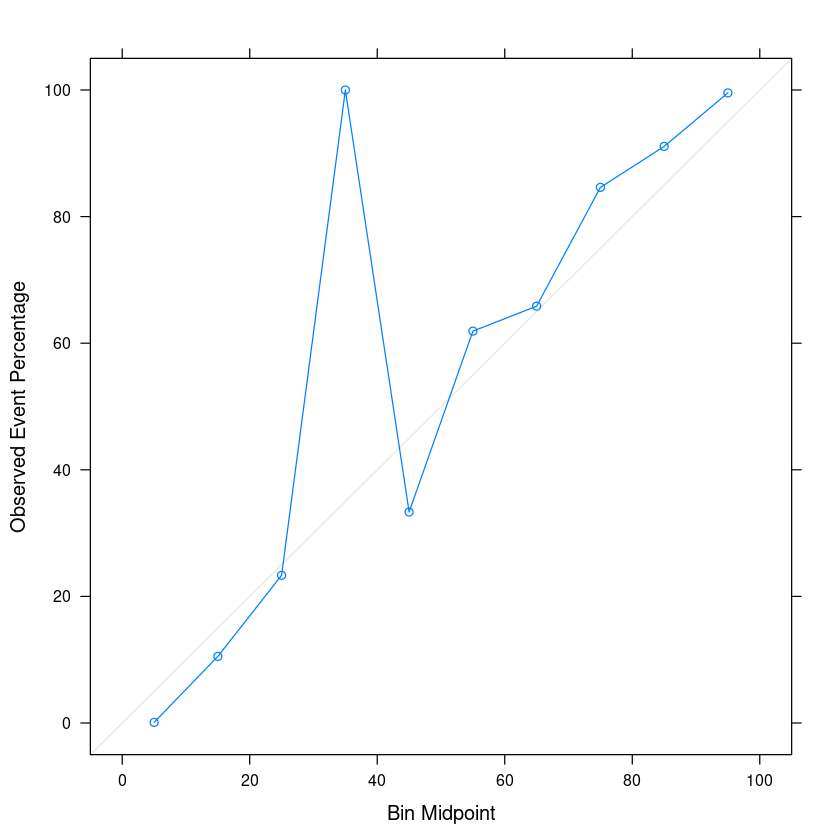

In [85]:
xyplot(cal_curve_rF)

In [98]:
head(result_rF)

,obs,pred_prob,calibrated
,<fct>,<dbl>,<dbl>
1,No,0.0000000000,0.000000e+00
2,No,0.0007096774,1.141419e-05
3,No,0.0113000000,1.817450e-04
4,No,0.0011071429,1.780688e-05
5,No,0.0000000000,0.000000e+00
6,No,0.0503452381,8.097343e-04


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



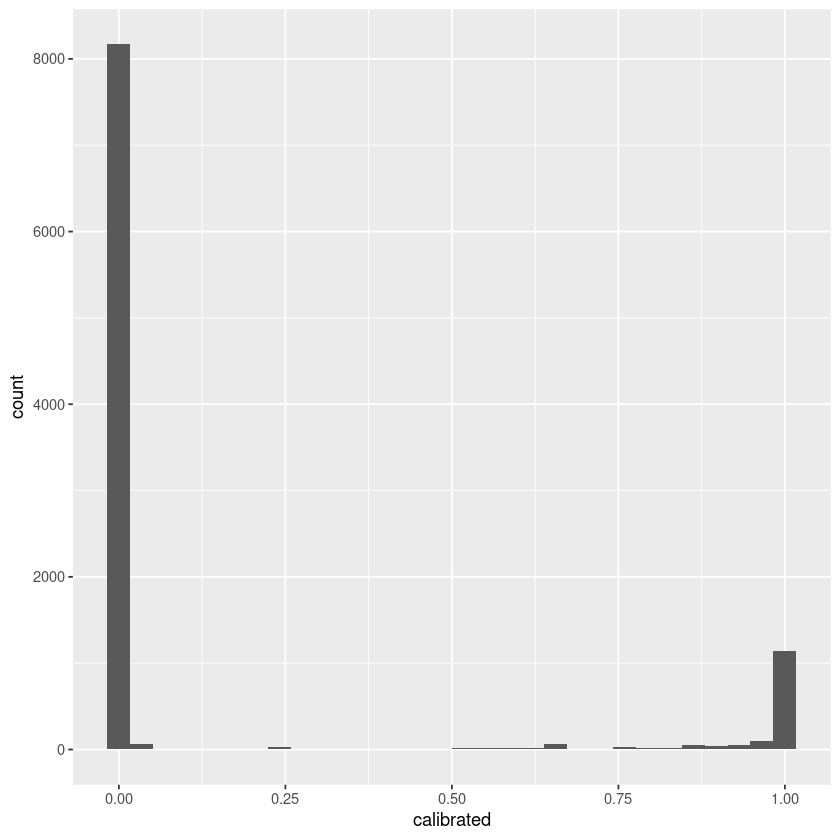

In [99]:
result_rF %>% 
    ggplot(aes(calibrated)) + 
        geom_histogram()

In [100]:
pd <- pdp::partial(retention_model_prob,
              pred.var = c("PageValues"),
              chull = TRUE,
              which.class=2,
              type="classification",
             )

Warning message:
“Use of `object[[1L]]` is discouraged. Use `.data[[1L]]` instead.”
Warning message:
“Use of `object[["yhat"]]` is discouraged. Use `.data[["yhat"]]` instead.”


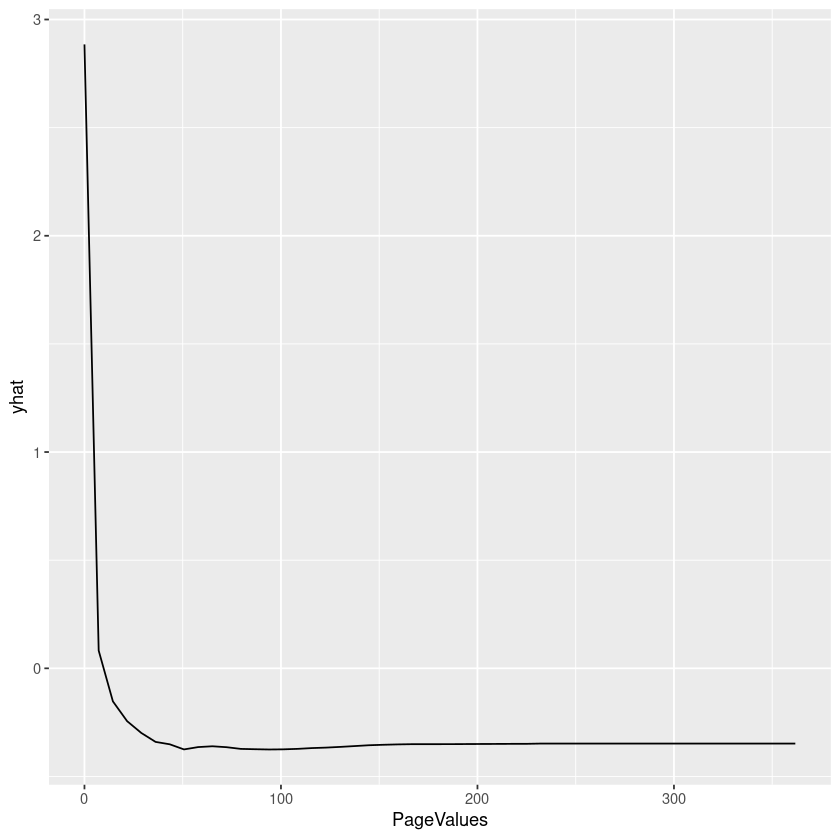

In [101]:
autoplot(pd, contour = TRUE)

### Tunning
#### Custom tunning

### Caret tunning
[doc](https://topepo.github.io/caret/measuring-performance.html#measures-for-predicted-classes)

Uno de los detalles al usar caret es que si no le damos por ejemplo las etapas de preprocesado, caret convierte las variables categoricas con one-hot encoding lo cual lleva a tener un monto de features

#### Sin Recipe en la formula

In [87]:
set.seed(42)
n_features <- length(retention_train_clean) - 1

tune_grid <-  expand.grid(
    mtry = c(2, 4, 8, 10),
    min.node.size = c(1, 3, 10), 
    splitrule = "gini"
    #n_trees = c(100, 200, 500, 1000),
    #replace = c(TRUE, FALSE),                               
    #sample.fraction = c(.5, .63, .8),                       
)

fitControl <- trainControl(method = "CV",
                           number = 5,
                           verboseIter = TRUE,
                           classProbs=TRUE,
                           #summaryFunction = twoClassSummary
                           summaryFunction = prSummary
                          )

retention_tune_model1 = train(
    Revenue ~ .,
    data = retention_train_clean,
    method = 'ranger',
    #metric = "Accuracy",
    tuneGrid = tune_grid,
    trControl = fitControl,
    num.trees = 500,
    replace = TRUE,
    sample.fraction = 1,
    importance = "impurity"
)


Warning message in train.default(x, y, weights = w, ...):
“The metric "Accuracy" was not in the result set. AUC will be used instead.”


+ Fold1: mtry= 2, min.node.size= 1, splitrule=gini 
- Fold1: mtry= 2, min.node.size= 1, splitrule=gini 
+ Fold1: mtry= 4, min.node.size= 1, splitrule=gini 
- Fold1: mtry= 4, min.node.size= 1, splitrule=gini 
+ Fold1: mtry= 8, min.node.size= 1, splitrule=gini 
- Fold1: mtry= 8, min.node.size= 1, splitrule=gini 
+ Fold1: mtry=10, min.node.size= 1, splitrule=gini 
- Fold1: mtry=10, min.node.size= 1, splitrule=gini 
+ Fold1: mtry= 2, min.node.size= 3, splitrule=gini 
- Fold1: mtry= 2, min.node.size= 3, splitrule=gini 
+ Fold1: mtry= 4, min.node.size= 3, splitrule=gini 
- Fold1: mtry= 4, min.node.size= 3, splitrule=gini 
+ Fold1: mtry= 8, min.node.size= 3, splitrule=gini 
- Fold1: mtry= 8, min.node.size= 3, splitrule=gini 
+ Fold1: mtry=10, min.node.size= 3, splitrule=gini 
- Fold1: mtry=10, min.node.size= 3, splitrule=gini 
+ Fold1: mtry= 2, min.node.size=10, splitrule=gini 
- Fold1: mtry= 2, min.node.size=10, splitrule=gini 
+ Fold1: mtry= 4, min.node.size=10, splitrule=gini 
- Fold1: mtr

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


Aggregating results
Selecting tuning parameters
Fitting mtry = 10, splitrule = gini, min.node.size = 1 on full training set


Random Forest 

9865 samples
  17 predictor
   2 classes: 'Yes', 'No' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 7892, 7892, 7892, 7892, 7892 
Resampling results across tuning parameters:

  mtry  min.node.size  AUC        Precision  Recall      F         
   2     1             0.5417453        NaN  0.00000000         NaN
   2     3             0.5370991        NaN  0.00000000         NaN
   2    10             0.5277833        NaN  0.00000000         NaN
   4     1             0.5954041        NaN  0.00000000         NaN
   4     3             0.6003785        NaN  0.00000000         NaN
   4    10             0.5929518        NaN  0.00000000         NaN
   8     1             0.6810599  0.9077967  0.06222865  0.11605493
   8     3             0.6738983  0.8784993  0.05240330  0.09837055
   8    10             0.6747007  0.8416667  0.05765134  0.10746426
  10     1             0.6981555  0.8539284  0.19322833  0.31396743
  10     3             

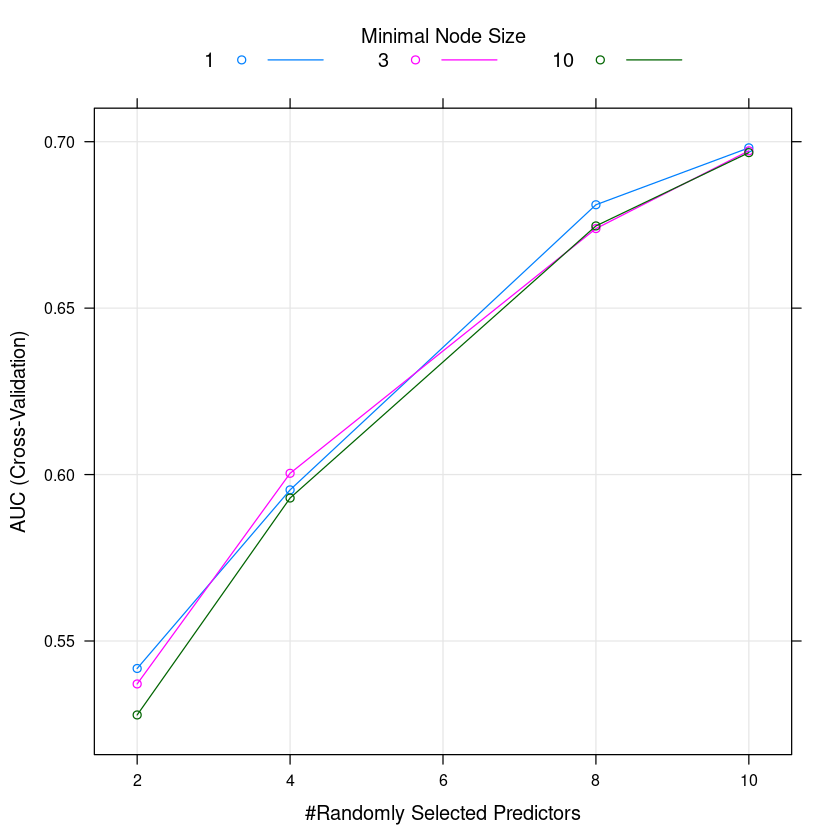

In [88]:
retention_tune_model1
plot(retention_tune_model1)

In [89]:
retention_tune_model1$finalModel

Ranger result

Call:
 ranger::ranger(dependent.variable.name = ".outcome", data = x,      mtry = min(param$mtry, ncol(x)), min.node.size = param$min.node.size,      splitrule = as.character(param$splitrule), write.forest = TRUE,      probability = classProbs, ...) 

Type:                             Probability estimation 
Number of trees:                  500 
Sample size:                      9865 
Number of independent variables:  396 
Mtry:                             10 
Target node size:                 1 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error (Brier s.):  0.08380507 

#### Con Recipe en la formula

In [90]:
retention_recipe <- recipe(Revenue ~ ., data = retention_train) %>%
    step_medianimpute(all_of(numerical)) %>% 
    step_string2factor(all_of(categorical)) %>% 
    step_knnimpute(all_of(categorical)) %>% 
    step_mutate(Revenue = factor(Revenue, labels=c("Yes", "No"), levels = c(TRUE, FALSE)))


set.seed(42)
n_features <- length(retention_train_clean) - 1

tune_grid <-  expand.grid(
    mtry = c(2, 4, 8, 10),
    min.node.size = c(1, 3, 10), 
    splitrule = "gini"
    #n_trees = c(100, 200, 500, 1000),
    #replace = c(TRUE, FALSE),                               
    #sample.fraction = c(.5, .63, .8),                       
)

fitControl <- trainControl(method = "CV",
                           number = 5,
                           verboseIter = TRUE,
                           classProbs=TRUE,
                           #summaryFunction = twoClassSummary
                           summaryFunction = prSummary
                          )

retention_tune_model2 = train(
    retention_recipe,
    data = retention_train,
    method = 'ranger',
    metric = "Accuracy",
    tuneGrid = tune_grid,
    trControl = fitControl,
    num.trees = 500,
    replace = TRUE,
    sample.fraction = 1,
    importance = "impurity"
)


Preparing recipe


Warning message in train.recipe(retention_recipe, data = retention_train, method = "ranger", :
“The metric "Accuracy" was not in the result set. AUC will be used instead.”


+ Fold1: mtry= 2, min.node.size= 1, splitrule=gini 
- Fold1: mtry= 2, min.node.size= 1, splitrule=gini 
+ Fold1: mtry= 4, min.node.size= 1, splitrule=gini 
- Fold1: mtry= 4, min.node.size= 1, splitrule=gini 
+ Fold1: mtry= 8, min.node.size= 1, splitrule=gini 
- Fold1: mtry= 8, min.node.size= 1, splitrule=gini 
+ Fold1: mtry=10, min.node.size= 1, splitrule=gini 
- Fold1: mtry=10, min.node.size= 1, splitrule=gini 
+ Fold1: mtry= 2, min.node.size= 3, splitrule=gini 
- Fold1: mtry= 2, min.node.size= 3, splitrule=gini 
+ Fold1: mtry= 4, min.node.size= 3, splitrule=gini 
- Fold1: mtry= 4, min.node.size= 3, splitrule=gini 
+ Fold1: mtry= 8, min.node.size= 3, splitrule=gini 
- Fold1: mtry= 8, min.node.size= 3, splitrule=gini 
+ Fold1: mtry=10, min.node.size= 3, splitrule=gini 
- Fold1: mtry=10, min.node.size= 3, splitrule=gini 
+ Fold1: mtry= 2, min.node.size=10, splitrule=gini 
- Fold1: mtry= 2, min.node.size=10, splitrule=gini 
+ Fold1: mtry= 4, min.node.size=10, splitrule=gini 
- Fold1: mtr

Random Forest 

9865 samples
  17 predictor
   2 classes: 'Yes', 'No' 

Recipe steps: medianimpute, string2factor, knnimpute, mutate 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 7892, 7892, 7892, 7892, 7892 
Resampling results across tuning parameters:

  mtry  min.node.size  AUC        Precision  Recall     F        
   2     1             0.7369705  0.7618545  0.5049802  0.6066200
   2     3             0.7397967  0.7670322  0.5134791  0.6145984
   2    10             0.7388351  0.7666502  0.5082374  0.6107475
   4     1             0.7401396  0.7280433  0.5645580  0.6354432
   4     3             0.7413793  0.7315210  0.5737148  0.6425735
   4    10             0.7434794  0.7331245  0.5743748  0.6436776
   8     1             0.7373292  0.7172186  0.5927033  0.6484558
   8     3             0.7377808  0.7197899  0.5894289  0.6476008
   8    10             0.7386809  0.7194410  0.5907404  0.6483326
  10     1             0.7333586  0.7110566  0.5894396  0.6439346
 

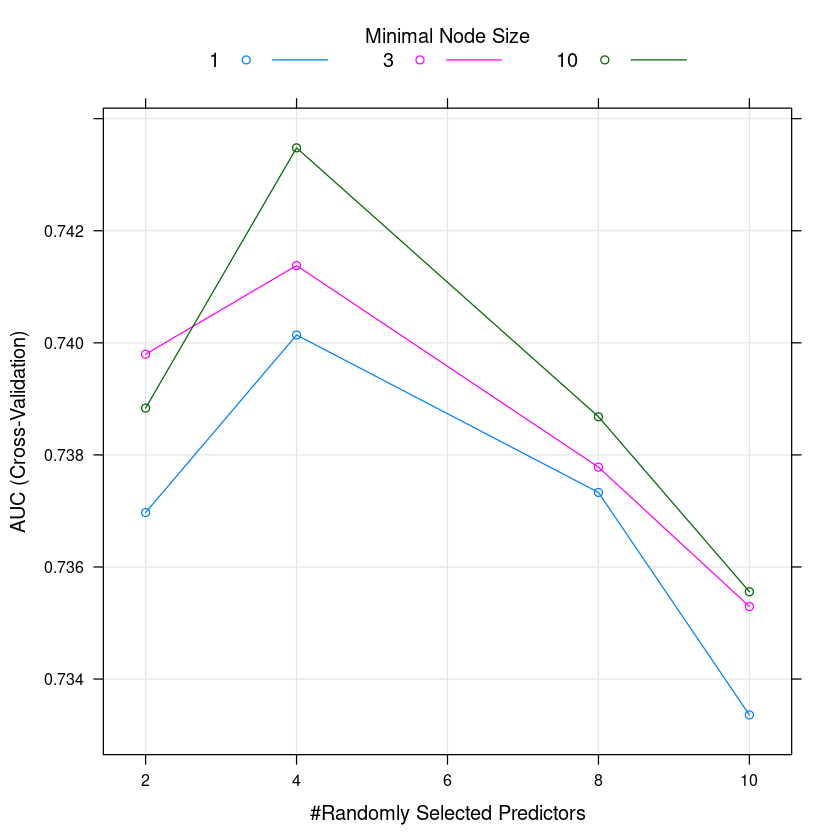

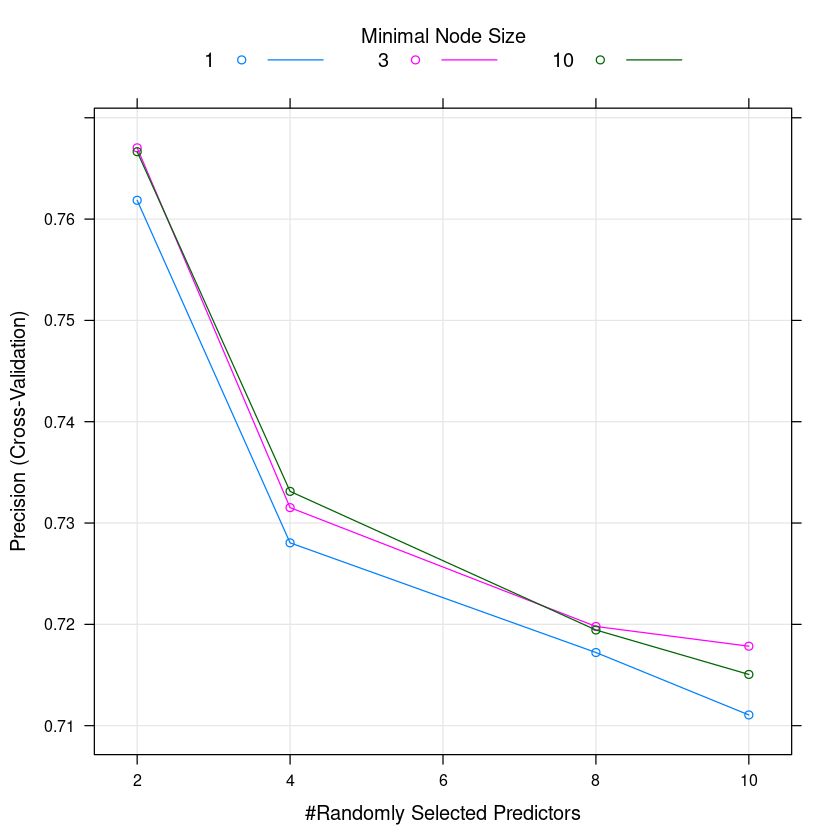

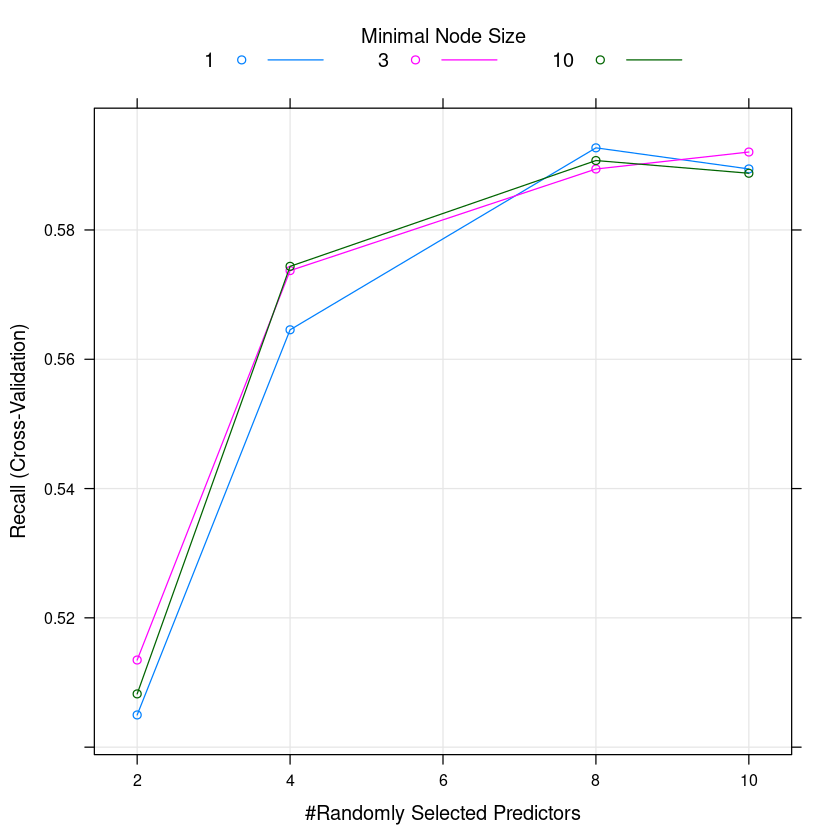

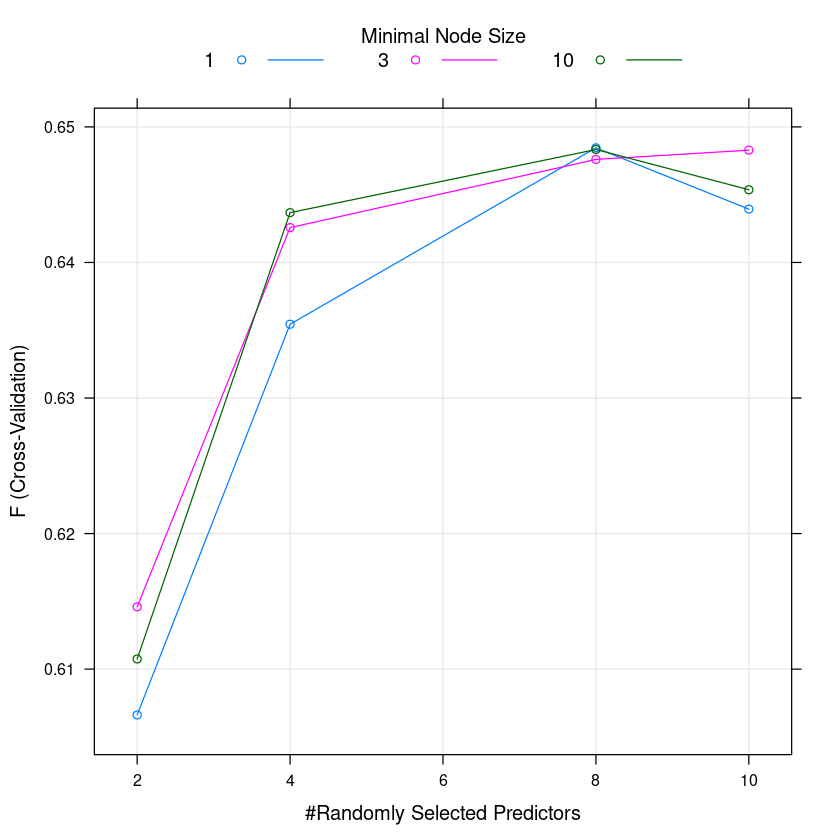

In [91]:
retention_tune_model2
plot(retention_tune_model2)
plot(retention_tune_model2, metric = "Precision")
plot(retention_tune_model2, metric = "Recall")
plot(retention_tune_model2, metric = "F")

In [92]:
retention_tune_model2$results

,mtry,min.node.size,splitrule,AUC,Precision,Recall,F,AUCSD,PrecisionSD,RecallSD,FSD
,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,1,gini,0.7369705,0.7618545,0.5049802,0.6066200,0.02958723,0.019560940,0.04921326,0.04096189
2,2,3,gini,0.7397967,0.7670322,0.5134791,0.6145984,0.02560551,0.018810645,0.03817312,0.03055354
3,2,10,gini,0.7388351,0.7666502,0.5082374,0.6107475,0.02599618,0.017425391,0.03683425,0.02976332
4,4,1,gini,0.7401396,0.7280433,0.5645580,0.6354432,0.02512291,0.018825076,0.03879750,0.02828002
5,4,3,gini,0.7413793,0.7315210,0.5737148,0.6425735,0.02253835,0.017018948,0.03353559,0.02240840
6,4,10,gini,0.7434794,0.7331245,0.5743748,0.6436776,0.02300329,0.012574218,0.03714266,0.02634194
7,8,1,gini,0.7373292,0.7172186,0.5927033,0.6484558,0.02083339,0.017167055,0.03089428,0.01641512
8,8,3,gini,0.7377808,0.7197899,0.5894289,0.6476008,0.02152058,0.014858687,0.03298632,0.01977182
9,8,10,gini,0.7386809,0.7194410,0.5907404,0.6483326,0.02186044,0.012288737,0.03315913,0.02079765


In [93]:
data_to_eval = retention_train_clean
pred_train_class <- as.factor(predict(retention_tune_model2, data_to_eval))
cm <- confusionMatrix(
  data = pred_train_class, 
  reference = data_to_eval$Revenue,
  mode='prec_recall'
)
cm

Confusion Matrix and Statistics

          Reference
Prediction  Yes   No
       Yes 1305   18
       No   222 8320
                                          
               Accuracy : 0.9757          
                 95% CI : (0.9724, 0.9786)
    No Information Rate : 0.8452          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9017          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
              Precision : 0.9864          
                 Recall : 0.8546          
                     F1 : 0.9158          
             Prevalence : 0.1548          
         Detection Rate : 0.1323          
   Detection Prevalence : 0.1341          
      Balanced Accuracy : 0.9262          
                                          
       'Positive' Class : Yes             
                                          

In [97]:
data_to_eval = retention_test_clean
pred_train_class <- as.factor(predict(retention_tune_model2, data_to_eval))
cm <- confusionMatrix(
  data = pred_train_class, 
  reference = data_to_eval$Revenue,
  mode='prec_recall'
)
cm

Confusion Matrix and Statistics

          Reference
Prediction  Yes   No
       Yes  226   94
       No   155 1990
                                          
               Accuracy : 0.899           
                 95% CI : (0.8864, 0.9106)
    No Information Rate : 0.8454          
    P-Value [Acc > NIR] : 5.325e-15       
                                          
                  Kappa : 0.5864          
                                          
 Mcnemar's Test P-Value : 0.0001433       
                                          
              Precision : 0.70625         
                 Recall : 0.59318         
                     F1 : 0.64479         
             Prevalence : 0.15456         
         Detection Rate : 0.09168         
   Detection Prevalence : 0.12982         
      Balanced Accuracy : 0.77404         
                                          
       'Positive' Class : Yes             
                                          

In [94]:
retention_tune_model2

Random Forest 

9865 samples
  17 predictor
   2 classes: 'Yes', 'No' 

Recipe steps: medianimpute, string2factor, knnimpute, mutate 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 7892, 7892, 7892, 7892, 7892 
Resampling results across tuning parameters:

  mtry  min.node.size  AUC        Precision  Recall     F        
   2     1             0.7369705  0.7618545  0.5049802  0.6066200
   2     3             0.7397967  0.7670322  0.5134791  0.6145984
   2    10             0.7388351  0.7666502  0.5082374  0.6107475
   4     1             0.7401396  0.7280433  0.5645580  0.6354432
   4     3             0.7413793  0.7315210  0.5737148  0.6425735
   4    10             0.7434794  0.7331245  0.5743748  0.6436776
   8     1             0.7373292  0.7172186  0.5927033  0.6484558
   8     3             0.7377808  0.7197899  0.5894289  0.6476008
   8    10             0.7386809  0.7194410  0.5907404  0.6483326
  10     1             0.7333586  0.7110566  0.5894396  0.6439346
 

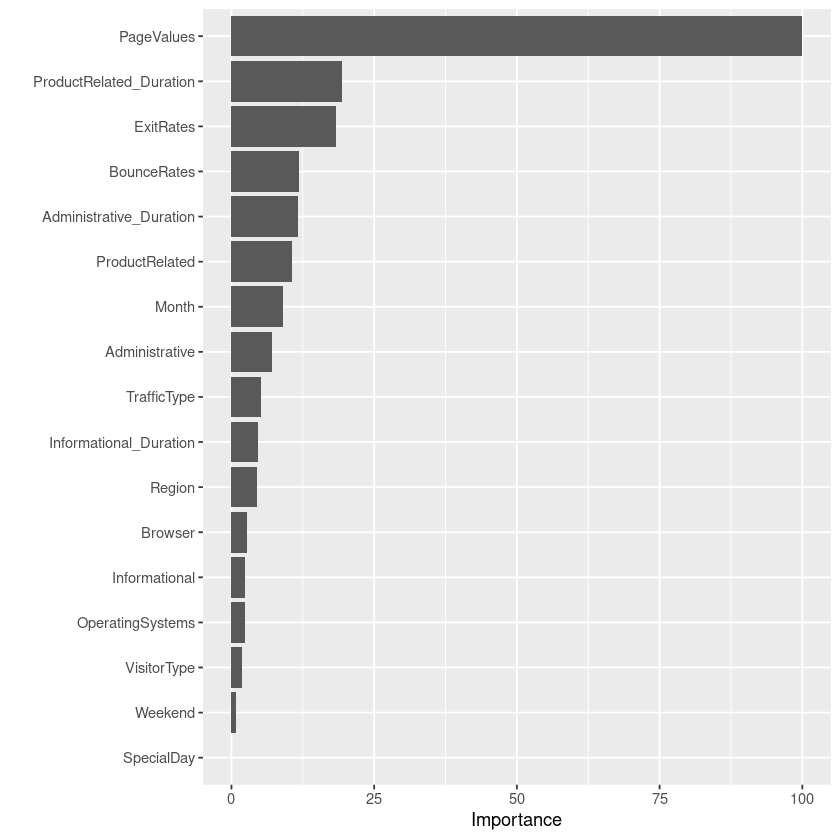

In [95]:
p1 <- vip::vip(retention_tune_model2, num_features = 25, )
p1

In [96]:
retention_tune_model2$finalModel

Ranger result

Call:
 ranger::ranger(dependent.variable.name = ".outcome", data = x,      mtry = min(param$mtry, ncol(x)), min.node.size = param$min.node.size,      splitrule = as.character(param$splitrule), write.forest = TRUE,      probability = classProbs, ...) 

Type:                             Probability estimation 
Number of trees:                  500 
Sample size:                      9865 
Number of independent variables:  17 
Mtry:                             4 
Target node size:                 10 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error (Brier s.):  0.0698046 